In [1]:
from pyomo.environ import *
from math import pi
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

With storage:
    
    optimal value = 418,522.42 USD
    
    total wind curtailment = 0.0569 pu
    
    
Without storage:

    optimal value = 432,857 USD
    
    wind curtailment=      1.4102  pu

## constants

In [2]:
Sbase = 100  # MVA

VOLL = 10000  # Value of lost load. £10,000 / MWh

VOLW = 50  # Value of wind curtailment £/MWh

eta_c = 0.95

eta_d = 0.9

storage_pos=0

## generator data

In [3]:
GD = {                                                                          
    ('g1', 'Pmax'): 400,  # MW
    ('g1', 'Pmin'): 100,  # MW
    ('g1', 'b'): 5.47,    # $/MW 
    ('g1', 'RU'): 47,     # MW/h
    ('g1', 'RD'): 47,     # MW/h
    
    ('g2', 'Pmax'): 400, 
    ('g2', 'Pmin'): 100, 
    ('g2', 'b'): 5.47, 
    ('g2', 'RU'): 47,
    ('g2', 'RD'): 47, 
    
    ('g3', 'Pmax'): 152, 
    ('g3', 'Pmin'): 30.4,
    ('g3', 'b'): 13.32, 
    ('g3', 'RU'): 14, 
    ('g3', 'RD'): 14, 
    
    ('g4', 'Pmax'): 152, 
    ('g4', 'Pmin'): 30.4, 
    ('g4', 'b'): 13.32, 
    ('g4', 'RU'): 14, 
    ('g4', 'RD'): 14, 
    
    ('g5', 'Pmax'): 155, 
    ('g5', 'Pmin'): 54.25,
    ('g5', 'b'): 16, 
    ('g5', 'RU'): 21,
    ('g5', 'RD'): 21, 
    
    ('g6', 'Pmax'): 155,
    ('g6', 'Pmin'): 54.25,
    ('g6', 'b'): 10.52, 
    ('g6', 'RU'): 21, 
    ('g6', 'RD'): 21, 
    
    ('g7', 'Pmax'): 310, 
    ('g7', 'Pmin'): 108.5, 
    ('g7', 'b'): 10.52, 
    ('g7', 'RU'): 21, 
    ('g7', 'RD'): 21, 

    ('g8', 'Pmax'): 350, 
    ('g8', 'Pmin'): 140, 
    ('g8', 'b'): 10.89, 
    ('g8', 'RU'): 28, 
    ('g8', 'RD'): 28, 
    
    ('g9', 'Pmax'): 350, 
    ('g9', 'Pmin'): 75, 
    ('g9', 'b'): 20.7, 
    ('g9', 'RU'): 49, 
    ('g9', 'RD'): 49, 
    
    ('g10', 'Pmax'): 591, 
    ('g10', 'Pmin'): 206.85, 
    ('g10', 'b'): 20.93, 
    ('g10', 'RU'): 21, 
    ('g10', 'RD'): 21, 
   
    ('g11', 'Pmax'): 60,
    ('g11', 'Pmin'): 12, 
    ('g11', 'b'): 26.11, 
    ('g11', 'RU'): 7, 
    ('g11', 'RD'): 7, 
 
    ('g12', 'Pmax'): 300, 
    ('g12', 'Pmin'): 0, 
    ('g12', 'b'): 0, 
    ('g12', 'RU'): 35,
    ('g12', 'RD'): 35, 
}

### wind and load availabilities (values between 0 and 1)

In [4]:
WD = {                                                                                          
    't1': {'w': 0.0786666666666667, 'd': 0.684511335492475},
    't2': {'w': 0.0866666666666667, 'd': 0.644122690036197},
    't3': {'w': 0.117333333333333, 'd': 0.61306915602972},
    't4': {'w': 0.258666666666667, 'd': 0.599733282530006},
    't5': {'w': 0.361333333333333, 'd': 0.588874071251667},
    't6': {'w': 0.566666666666667, 'd': 0.5980186702229},
    't7': {'w': 0.650666666666667, 'd': 0.5980186702229},
    't8': {'w': 0.566666666666667, 'd': 0.651743189178891},
    't9': {'w': 0.484, 'd': 0.706039245570585},
    't10': {'w': 0.548, 'd': 0.787007048961707},
    't11': {'w': 0.757333333333333, 'd': 0.839016955610593},
    't12': {'w': 0.710666666666667, 'd': 0.852733854067441},
    't13': {'w': 0.870666666666667, 'd': 0.870642027052772},
    't14': {'w': 0.932, 'd': 0.834254143646409},
    't15': {'w': 0.966666666666667, 'd': 0.816536483139646},
    't16': {'w': 1, 'd': 0.819394170318156},
    't17': {'w': 0.869333333333333, 'd': 0.874071251666984},
    't18': {'w': 0.665333333333333, 'd': 1},
    't19': {'w': 0.656 , 'd': 0.983615926843208},
    't20': {'w': 0.561333333333333, 'd': 0.936368832158506},
    't21': {'w': 0.565333333333333, 'd': 0.887597637645266},
    't22': {'w': 0.556, 'd': 0.809297008954087},
    't23': {'w': 0.724, 'd': 0.74585635359116},
    't24': {'w': 0.84, 'd': 0.733473042484283}  
}



## model definition

In [5]:
model = ConcreteModel()

In [6]:
model.name = "multi-period ESS integrated DC-OPF"

### time periods

In [7]:
t_hours = [
    't1', 
    't2', 
    't3', 
    't4', 
    't5', 
    't6', 
    't7', 
    't8', 
    't9', 
    't10', 
    't11', 
    't12', 
    't13', 
    't14', 
    't15', 
    't16', 
    't17', 
    't18', 
    't19', 
    't20', 
    't21', 
    't22', 
    't23', 
    't24']

In [8]:
model.t = Set(initialize=t_hours)

## 24 busbars

In [9]:
model.bus = RangeSet(1, 24)

In [10]:
model.bus.at(1) #the first bus is '1'

1

In [11]:
model.node = RangeSet(1, 24)

In [12]:
#how you can see its elements:

list(model.bus)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [13]:
list(model.node)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

## Set of 12 generators

In [14]:
list_gens = [f'g{i}' for i in range(1, 13)]
list_gens

['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12']

In [15]:
model.Gen = Set(initialize=list_gens)

In [16]:
model.Gen.at(5) #the fifth generator is g5.

'g5'

In [17]:
list(model.Gen)

['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12']

## slack bus:

In [18]:
model.slack = Set(initialize=[13])

In [19]:
model.slack.at(1)

13

In [20]:
list(model.slack)

[13]

## which generator is connected to which bus

In [21]:
GB = {(bus, gen): 0 for bus in model.bus for gen in model.Gen}

In [22]:
type(GB)

dict

In [23]:
GB

{(1, 'g1'): 0,
 (1, 'g2'): 0,
 (1, 'g3'): 0,
 (1, 'g4'): 0,
 (1, 'g5'): 0,
 (1, 'g6'): 0,
 (1, 'g7'): 0,
 (1, 'g8'): 0,
 (1, 'g9'): 0,
 (1, 'g10'): 0,
 (1, 'g11'): 0,
 (1, 'g12'): 0,
 (2, 'g1'): 0,
 (2, 'g2'): 0,
 (2, 'g3'): 0,
 (2, 'g4'): 0,
 (2, 'g5'): 0,
 (2, 'g6'): 0,
 (2, 'g7'): 0,
 (2, 'g8'): 0,
 (2, 'g9'): 0,
 (2, 'g10'): 0,
 (2, 'g11'): 0,
 (2, 'g12'): 0,
 (3, 'g1'): 0,
 (3, 'g2'): 0,
 (3, 'g3'): 0,
 (3, 'g4'): 0,
 (3, 'g5'): 0,
 (3, 'g6'): 0,
 (3, 'g7'): 0,
 (3, 'g8'): 0,
 (3, 'g9'): 0,
 (3, 'g10'): 0,
 (3, 'g11'): 0,
 (3, 'g12'): 0,
 (4, 'g1'): 0,
 (4, 'g2'): 0,
 (4, 'g3'): 0,
 (4, 'g4'): 0,
 (4, 'g5'): 0,
 (4, 'g6'): 0,
 (4, 'g7'): 0,
 (4, 'g8'): 0,
 (4, 'g9'): 0,
 (4, 'g10'): 0,
 (4, 'g11'): 0,
 (4, 'g12'): 0,
 (5, 'g1'): 0,
 (5, 'g2'): 0,
 (5, 'g3'): 0,
 (5, 'g4'): 0,
 (5, 'g5'): 0,
 (5, 'g6'): 0,
 (5, 'g7'): 0,
 (5, 'g8'): 0,
 (5, 'g9'): 0,
 (5, 'g10'): 0,
 (5, 'g11'): 0,
 (5, 'g12'): 0,
 (6, 'g1'): 0,
 (6, 'g2'): 0,
 (6, 'g3'): 0,
 (6, 'g4'): 0,
 (6, 'g5'): 0,
 (6, 'g6')

In [24]:
GB_data = {
    (18, 'g1'): 1,
    (21, 'g2'): 1,
    (1, 'g3'): 1,
    (2, 'g4'): 1,
    (15, 'g5'): 1,
    (16, 'g6'): 1,
    (23, 'g7'): 1,
    (23, 'g8'): 1,
    (7,  'g9'): 1,
    (13, 'g10'): 1,
    (15, 'g11'): 1,
    (22, 'g12'): 1,
}

In [25]:
GB.update(GB_data)

In [26]:
GB

{(1, 'g1'): 0,
 (1, 'g2'): 0,
 (1, 'g3'): 1,
 (1, 'g4'): 0,
 (1, 'g5'): 0,
 (1, 'g6'): 0,
 (1, 'g7'): 0,
 (1, 'g8'): 0,
 (1, 'g9'): 0,
 (1, 'g10'): 0,
 (1, 'g11'): 0,
 (1, 'g12'): 0,
 (2, 'g1'): 0,
 (2, 'g2'): 0,
 (2, 'g3'): 0,
 (2, 'g4'): 1,
 (2, 'g5'): 0,
 (2, 'g6'): 0,
 (2, 'g7'): 0,
 (2, 'g8'): 0,
 (2, 'g9'): 0,
 (2, 'g10'): 0,
 (2, 'g11'): 0,
 (2, 'g12'): 0,
 (3, 'g1'): 0,
 (3, 'g2'): 0,
 (3, 'g3'): 0,
 (3, 'g4'): 0,
 (3, 'g5'): 0,
 (3, 'g6'): 0,
 (3, 'g7'): 0,
 (3, 'g8'): 0,
 (3, 'g9'): 0,
 (3, 'g10'): 0,
 (3, 'g11'): 0,
 (3, 'g12'): 0,
 (4, 'g1'): 0,
 (4, 'g2'): 0,
 (4, 'g3'): 0,
 (4, 'g4'): 0,
 (4, 'g5'): 0,
 (4, 'g6'): 0,
 (4, 'g7'): 0,
 (4, 'g8'): 0,
 (4, 'g9'): 0,
 (4, 'g10'): 0,
 (4, 'g11'): 0,
 (4, 'g12'): 0,
 (5, 'g1'): 0,
 (5, 'g2'): 0,
 (5, 'g3'): 0,
 (5, 'g4'): 0,
 (5, 'g5'): 0,
 (5, 'g6'): 0,
 (5, 'g7'): 0,
 (5, 'g8'): 0,
 (5, 'g9'): 0,
 (5, 'g10'): 0,
 (5, 'g11'): 0,
 (5, 'g12'): 0,
 (6, 'g1'): 0,
 (6, 'g2'): 0,
 (6, 'g3'): 0,
 (6, 'g4'): 0,
 (6, 'g5'): 0,
 (6, 'g6')

## demand per bus (MW)

In [27]:
BusData = {bus : {'pd' : 0} for bus in model.bus}

In [28]:
BusData

{1: {'pd': 0},
 2: {'pd': 0},
 3: {'pd': 0},
 4: {'pd': 0},
 5: {'pd': 0},
 6: {'pd': 0},
 7: {'pd': 0},
 8: {'pd': 0},
 9: {'pd': 0},
 10: {'pd': 0},
 11: {'pd': 0},
 12: {'pd': 0},
 13: {'pd': 0},
 14: {'pd': 0},
 15: {'pd': 0},
 16: {'pd': 0},
 17: {'pd': 0},
 18: {'pd': 0},
 19: {'pd': 0},
 20: {'pd': 0},
 21: {'pd': 0},
 22: {'pd': 0},
 23: {'pd': 0},
 24: {'pd': 0}}

In [29]:
BusData_ = {
    1: {'pd': 108},
    2: {'pd': 97},
    3: {'pd': 180},
    4: {'pd': 74},
    5: {'pd': 71},
    6: {'pd': 136},
    7: {'pd': 125},
    8: {'pd': 171},
    9: {'pd': 175},
    10: {'pd': 195},
    13: {'pd': 265},
    14: {'pd': 194},
    15: {'pd': 317},
    16: {'pd': 100},
    18: {'pd': 333},
    19: {'pd': 181},
    20: {'pd': 128},
}

In [30]:
BusData.update(BusData_)

In [31]:
BusData

{1: {'pd': 108},
 2: {'pd': 97},
 3: {'pd': 180},
 4: {'pd': 74},
 5: {'pd': 71},
 6: {'pd': 136},
 7: {'pd': 125},
 8: {'pd': 171},
 9: {'pd': 175},
 10: {'pd': 195},
 11: {'pd': 0},
 12: {'pd': 0},
 13: {'pd': 265},
 14: {'pd': 194},
 15: {'pd': 317},
 16: {'pd': 100},
 17: {'pd': 0},
 18: {'pd': 333},
 19: {'pd': 181},
 20: {'pd': 128},
 21: {'pd': 0},
 22: {'pd': 0},
 23: {'pd': 0},
 24: {'pd': 0}}

## Wind Capacity per bus

In [32]:
Wcap_data = {bus: 0 for bus in model.bus}

In [33]:
Wcap_data

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0}

In [34]:
Wcap_data[8] = 200
Wcap_data[19] = 150
Wcap_data[21] = 100

In [35]:
Wcap_data

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 200,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 150,
 20: 0,
 21: 100,
 22: 0,
 23: 0,
 24: 0}

In [36]:
# Wcap_data = {
#     8: 200,
#     19: 150,
#     21: 100,
# }

## SOCMax

In [37]:
# SOCMax = {    
#     19: 200,
#     21: 100,
# }

In [38]:
SOCMax = {bus: 0 for bus in model.bus}
SOCMax

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0}

In [39]:
SOCMax[19] = 200
SOCMax[21] = 100

In [40]:
SOCMax

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 200,
 20: 0,
 21: 100,
 22: 0,
 23: 0,
 24: 0}

## SOC0

In [41]:
SOC0 = {bus: 0.2 * SOCMax[bus]/Sbase for bus in model.bus}

In [42]:
SOC0

{1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.4,
 20: 0.0,
 21: 0.2,
 22: 0.0,
 23: 0.0,
 24: 0.0}

## Transmission lines technical data

In [43]:
branch_data = {                                                                       
    (1, 2): {'x': 0.0139, 'b': 0.4611, 'Limit': 175},   
    (1, 3): {'x': 0.2112, 'b': 0.0572, 'Limit': 175}, # x reactance in per unit
    (1, 5): {'x': 0.0845, 'b': 0.0229, 'Limit': 175}, # b susceptance in per unit
    (2, 4): {'x': 0.1267, 'b': 0.0343, 'Limit': 175}, # Limit in MVA
    (2, 6): {'x': 0.1920, 'b': 0.0520, 'Limit': 175},
    (3, 9): {'x': 0.1190, 'b': 0.0322, 'Limit': 175},
    (3, 24): {'x': 0.0839, 'b': 0.0000, 'Limit': 400},
    (4, 9): {'x': 0.1037, 'b': 0.0281, 'Limit': 175},
    (5, 10): {'x': 0.0883, 'b': 0.0239, 'Limit': 175},
    (6, 10): {'x': 0.0605, 'b': 2.4590, 'Limit': 175},
    (7, 8): {'x': 0.0614, 'b': 0.0166, 'Limit': 175},
    (8, 9): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
    (8, 10): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
    (9, 11): {'x': 0.0839, 'b': 0.0000, 'Limit': 400},
    (9, 12): {'x': 0.0839, 'b': 0.0000, 'Limit': 400},
    (10, 11): {'x': 0.0839, 'b': 0.0000, 'Limit': 400},
    (10, 12): {'x': 0.0839, 'b': 0.0000, 'Limit': 400},
    (11, 13): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
    (11, 14): {'x': 0.0418, 'b': 0.0879, 'Limit': 500},
    (12, 13): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
    (12, 23): {'x': 0.0966, 'b': 0.2030, 'Limit': 500},
    (13, 23): {'x': 0.0865, 'b': 0.1818, 'Limit': 500},
    (14, 16): {'x': 0.0389, 'b': 0.0818, 'Limit': 500},
    (15, 16): {'x': 0.0173, 'b': 0.0364, 'Limit': 500},
    (15, 21): {'x': 0.0245, 'b': 0.2060, 'Limit': 1000},
    (15, 24): {'x': 0.0519, 'b': 0.1091, 'Limit': 500},
    (16, 17): {'x': 0.0259, 'b': 0.0545, 'Limit': 500},
    (16, 19): {'x': 0.0231, 'b': 0.0485, 'Limit': 500},
    (17, 18): {'x': 0.0144, 'b': 0.0303, 'Limit': 500},
    (17, 22): {'x': 0.1053, 'b': 0.2212, 'Limit': 500},
    (18, 21): {'x': 0.0130, 'b': 0.1090, 'Limit': 1000},
    (19, 20): {'x': 0.0198, 'b': 0.1666, 'Limit': 1000},
    (20, 23): {'x': 0.0108, 'b': 0.0910, 'Limit': 1000},
    (21, 22): {'x': 0.0678, 'b': 0.1424, 'Limit': 500} 
}

In [44]:
branch_data

{(1, 2): {'x': 0.0139, 'b': 0.4611, 'Limit': 175},
 (1, 3): {'x': 0.2112, 'b': 0.0572, 'Limit': 175},
 (1, 5): {'x': 0.0845, 'b': 0.0229, 'Limit': 175},
 (2, 4): {'x': 0.1267, 'b': 0.0343, 'Limit': 175},
 (2, 6): {'x': 0.192, 'b': 0.052, 'Limit': 175},
 (3, 9): {'x': 0.119, 'b': 0.0322, 'Limit': 175},
 (3, 24): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (4, 9): {'x': 0.1037, 'b': 0.0281, 'Limit': 175},
 (5, 10): {'x': 0.0883, 'b': 0.0239, 'Limit': 175},
 (6, 10): {'x': 0.0605, 'b': 2.459, 'Limit': 175},
 (7, 8): {'x': 0.0614, 'b': 0.0166, 'Limit': 175},
 (8, 9): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (8, 10): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (9, 11): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (9, 12): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (10, 11): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (10, 12): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (11, 13): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (11, 14): {'x': 0.0418, 'b': 0.0879, 'Limit': 500},
 (12, 13): {'x': 0.0476, 'b': 0.0999

In [45]:
len(branch_data)

34

In [46]:
branch = {}

In [47]:
for bus in model.bus:
    for node in model.node:
        if (node, bus) in branch_data:
            branch[(bus, node)] = branch_data[ (node,bus) ]

In [48]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (11, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (13, 11): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (13, 12): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (14, 11): {'x': 0.0418, 'b': 0.0879, 'Limit': 500},
 (16, 14): {'x': 0.0389, 'b': 0.

In [49]:
len(branch)

34

In [50]:
branch.update(branch_data)  

In [51]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (11, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (13, 11): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (13, 12): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (14, 11): {'x': 0.0418, 'b': 0.0879, 'Limit': 500},
 (16, 14): {'x': 0.0389, 'b': 0.

In [52]:
len(branch)

68

In [53]:
for bus in model.bus:
    for node in model.node:
        if (node, bus) in branch_data:
            print(branch[(bus, node)]['x'] )

0.0139
0.2112
0.1267
0.0845
0.192
0.0614
0.119
0.1037
0.1651
0.0883
0.0605
0.1651
0.0839
0.0839
0.0839
0.0839
0.0476
0.0476
0.0418
0.0389
0.0173
0.0259
0.0144
0.0231
0.0198
0.0245
0.013
0.1053
0.0678
0.0966
0.0865
0.0108
0.0839
0.0519


Coloured circles indicatee Wind farms. Eg at bus 21 we have a 100MW wind farm.

Also at buses 19 and 21 we have energy storage. There is a symbol of a battery indicating this. And it makes sense to always accompany wind farms with storage

The white circles are generators. So for example, bus 17 does not have generators there.

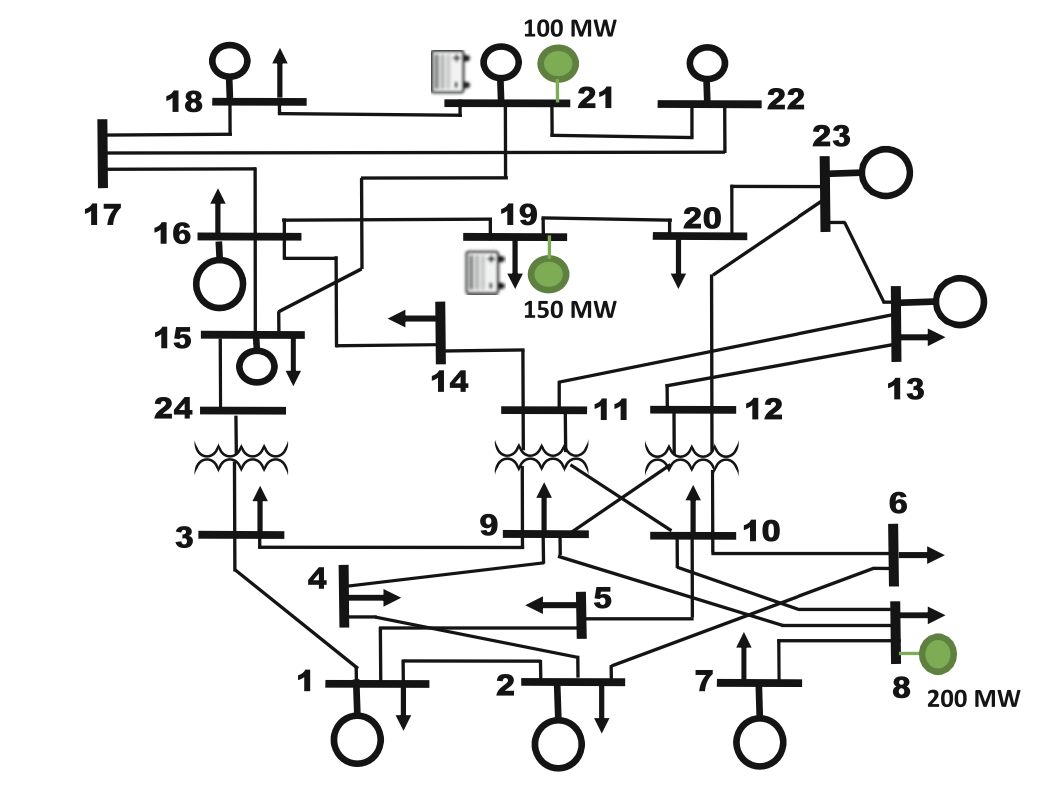

## Adding the bij in the branch data

In [54]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (11, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (13, 11): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (13, 12): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (14, 11): {'x': 0.0418, 'b': 0.0879, 'Limit': 500},
 (16, 14): {'x': 0.0389, 'b': 0.

In [55]:
len(branch)

68

In [56]:
branch[(1,2)]

{'x': 0.0139, 'b': 0.4611, 'Limit': 175}

In [57]:
#how we add a new value in the dictionary:

branch[(21,22)]['bij']=""

In [58]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (11, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (12, 10): {'x': 0.0839, 'b': 0.0, 'Limit': 400},
 (13, 11): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (13, 12): {'x': 0.0476, 'b': 0.0999, 'Limit': 500},
 (14, 11): {'x': 0.0418, 'b': 0.0879, 'Limit': 500},
 (16, 14): {'x': 0.0389, 'b': 0.

In [59]:
for (bus, node) in branch:
    branch[ (bus, node) ]['bij'] = 1/branch[bus, node]['x']

In [60]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175, 'bij': 71.94244604316548},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175, 'bij': 4.734848484848485},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175, 'bij': 7.892659826361483},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175, 'bij': 11.834319526627219},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175, 'bij': 5.208333333333333},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175, 'bij': 16.286644951140065},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175, 'bij': 8.403361344537815},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175, 'bij': 9.643201542912246},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175, 'bij': 11.325028312570781},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175, 'bij': 16.528925619834713},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400, 'bij': 11.9189511323003

## Bus-to-bus connection

In [61]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175, 'bij': 71.94244604316548},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175, 'bij': 4.734848484848485},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175, 'bij': 7.892659826361483},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175, 'bij': 11.834319526627219},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175, 'bij': 5.208333333333333},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175, 'bij': 16.286644951140065},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175, 'bij': 8.403361344537815},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175, 'bij': 9.643201542912246},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175, 'bij': 11.325028312570781},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175, 'bij': 16.528925619834713},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400, 'bij': 11.9189511323003

In [62]:
for (x,z) in branch.items():
    print("x=", x, "z=", z)

x= (2, 1) z= {'x': 0.0139, 'b': 0.4611, 'Limit': 175, 'bij': 71.94244604316548}
x= (3, 1) z= {'x': 0.2112, 'b': 0.0572, 'Limit': 175, 'bij': 4.734848484848485}
x= (4, 2) z= {'x': 0.1267, 'b': 0.0343, 'Limit': 175, 'bij': 7.892659826361483}
x= (5, 1) z= {'x': 0.0845, 'b': 0.0229, 'Limit': 175, 'bij': 11.834319526627219}
x= (6, 2) z= {'x': 0.192, 'b': 0.052, 'Limit': 175, 'bij': 5.208333333333333}
x= (8, 7) z= {'x': 0.0614, 'b': 0.0166, 'Limit': 175, 'bij': 16.286644951140065}
x= (9, 3) z= {'x': 0.119, 'b': 0.0322, 'Limit': 175, 'bij': 8.403361344537815}
x= (9, 4) z= {'x': 0.1037, 'b': 0.0281, 'Limit': 175, 'bij': 9.643201542912246}
x= (9, 8) z= {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585}
x= (10, 5) z= {'x': 0.0883, 'b': 0.0239, 'Limit': 175, 'bij': 11.325028312570781}
x= (10, 6) z= {'x': 0.0605, 'b': 2.459, 'Limit': 175, 'bij': 16.528925619834713}
x= (10, 8) z= {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585}
x= (11, 9) z= {'x': 0.0839, 'b': 0.

In [63]:
for (x,y),z in branch.items():
    print("x=",x,"y=", y,"z=", z)

x= 2 y= 1 z= {'x': 0.0139, 'b': 0.4611, 'Limit': 175, 'bij': 71.94244604316548}
x= 3 y= 1 z= {'x': 0.2112, 'b': 0.0572, 'Limit': 175, 'bij': 4.734848484848485}
x= 4 y= 2 z= {'x': 0.1267, 'b': 0.0343, 'Limit': 175, 'bij': 7.892659826361483}
x= 5 y= 1 z= {'x': 0.0845, 'b': 0.0229, 'Limit': 175, 'bij': 11.834319526627219}
x= 6 y= 2 z= {'x': 0.192, 'b': 0.052, 'Limit': 175, 'bij': 5.208333333333333}
x= 8 y= 7 z= {'x': 0.0614, 'b': 0.0166, 'Limit': 175, 'bij': 16.286644951140065}
x= 9 y= 3 z= {'x': 0.119, 'b': 0.0322, 'Limit': 175, 'bij': 8.403361344537815}
x= 9 y= 4 z= {'x': 0.1037, 'b': 0.0281, 'Limit': 175, 'bij': 9.643201542912246}
x= 9 y= 8 z= {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585}
x= 10 y= 5 z= {'x': 0.0883, 'b': 0.0239, 'Limit': 175, 'bij': 11.325028312570781}
x= 10 y= 6 z= {'x': 0.0605, 'b': 2.459, 'Limit': 175, 'bij': 16.528925619834713}
x= 10 y= 8 z= {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585}
x= 11 y= 9 z= {'x': 0.0839, 'b': 0.

In [64]:
for (x,y),z in branch.items():
    print(z['Limit'])

175
175
175
175
175
175
175
175
175
175
175
175
400
400
400
400
500
500
500
500
500
500
500
500
1000
1000
1000
500
500
500
500
1000
400
500
175
175
175
175
175
175
400
175
175
175
175
175
175
400
400
400
400
500
500
500
500
500
500
500
1000
500
500
500
500
500
1000
1000
1000
500


In [65]:
conex = {}

In [66]:
for (bus,node), row in branch.items():
    if row['Limit'] :
        conex[bus,node] = 1

In [67]:
conex

{(2, 1): 1,
 (3, 1): 1,
 (4, 2): 1,
 (5, 1): 1,
 (6, 2): 1,
 (8, 7): 1,
 (9, 3): 1,
 (9, 4): 1,
 (9, 8): 1,
 (10, 5): 1,
 (10, 6): 1,
 (10, 8): 1,
 (11, 9): 1,
 (11, 10): 1,
 (12, 9): 1,
 (12, 10): 1,
 (13, 11): 1,
 (13, 12): 1,
 (14, 11): 1,
 (16, 14): 1,
 (16, 15): 1,
 (17, 16): 1,
 (18, 17): 1,
 (19, 16): 1,
 (20, 19): 1,
 (21, 15): 1,
 (21, 18): 1,
 (22, 17): 1,
 (22, 21): 1,
 (23, 12): 1,
 (23, 13): 1,
 (23, 20): 1,
 (24, 3): 1,
 (24, 15): 1,
 (1, 2): 1,
 (1, 3): 1,
 (1, 5): 1,
 (2, 4): 1,
 (2, 6): 1,
 (3, 9): 1,
 (3, 24): 1,
 (4, 9): 1,
 (5, 10): 1,
 (6, 10): 1,
 (7, 8): 1,
 (8, 9): 1,
 (8, 10): 1,
 (9, 11): 1,
 (9, 12): 1,
 (10, 11): 1,
 (10, 12): 1,
 (11, 13): 1,
 (11, 14): 1,
 (12, 13): 1,
 (12, 23): 1,
 (13, 23): 1,
 (14, 16): 1,
 (15, 16): 1,
 (15, 21): 1,
 (15, 24): 1,
 (16, 17): 1,
 (16, 19): 1,
 (17, 18): 1,
 (17, 22): 1,
 (18, 21): 1,
 (19, 20): 1,
 (20, 23): 1,
 (21, 22): 1}

alternatively we can write it as follows:

In [68]:
conex = {(bus, node): 1 for (bus, node), row in branch.items() if row['Limit']}

In [69]:
conex

{(2, 1): 1,
 (3, 1): 1,
 (4, 2): 1,
 (5, 1): 1,
 (6, 2): 1,
 (8, 7): 1,
 (9, 3): 1,
 (9, 4): 1,
 (9, 8): 1,
 (10, 5): 1,
 (10, 6): 1,
 (10, 8): 1,
 (11, 9): 1,
 (11, 10): 1,
 (12, 9): 1,
 (12, 10): 1,
 (13, 11): 1,
 (13, 12): 1,
 (14, 11): 1,
 (16, 14): 1,
 (16, 15): 1,
 (17, 16): 1,
 (18, 17): 1,
 (19, 16): 1,
 (20, 19): 1,
 (21, 15): 1,
 (21, 18): 1,
 (22, 17): 1,
 (22, 21): 1,
 (23, 12): 1,
 (23, 13): 1,
 (23, 20): 1,
 (24, 3): 1,
 (24, 15): 1,
 (1, 2): 1,
 (1, 3): 1,
 (1, 5): 1,
 (2, 4): 1,
 (2, 6): 1,
 (3, 9): 1,
 (3, 24): 1,
 (4, 9): 1,
 (5, 10): 1,
 (6, 10): 1,
 (7, 8): 1,
 (8, 9): 1,
 (8, 10): 1,
 (9, 11): 1,
 (9, 12): 1,
 (10, 11): 1,
 (10, 12): 1,
 (11, 13): 1,
 (11, 14): 1,
 (12, 13): 1,
 (12, 23): 1,
 (13, 23): 1,
 (14, 16): 1,
 (15, 16): 1,
 (15, 21): 1,
 (15, 24): 1,
 (16, 17): 1,
 (16, 19): 1,
 (17, 18): 1,
 (17, 22): 1,
 (18, 21): 1,
 (19, 20): 1,
 (20, 23): 1,
 (21, 22): 1}

## Decision Variables

## delta (voltage angle)

In [70]:
pi

3.141592653589793

In [71]:
model.delta = Var(model.bus, model.t, bounds=(-pi/2, pi/2))

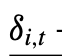

## delta at slack bus is zero

In [72]:
for t in model.t:
    for slack in model.slack:
        model.delta[slack, t].fix(0)

## Generator output (in per unit)

In [73]:
def Pmin(model, gen, t):
    return GD[gen,'Pmin'] / Sbase

In [74]:
def Pmax(model, gen, t):
    return GD[gen,'Pmax'] / Sbase

In [75]:
model.Pg = Var(model.Gen, model.t, bounds=lambda m, gen, t: (Pmin(m, gen, t), Pmax(m, gen, t)))


## power flow 

In [76]:
def Limit(model, bus, node, t):
    if (bus, node) in branch:
        lim = branch[bus, node]['Limit'] / Sbase
        return (-lim, lim)
    else:
        return (0.0, 0.0)

In [77]:
#model.Pij = Var(model.bus, model.node, model.t, bounds=Limit)


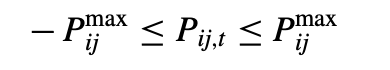

In [78]:
model.Pij = Var(model.bus, model.node, model.t, bounds= lambda m , b, n, t : Limit(m,b,n,t)  )

In [79]:
branch

{(2, 1): {'x': 0.0139, 'b': 0.4611, 'Limit': 175, 'bij': 71.94244604316548},
 (3, 1): {'x': 0.2112, 'b': 0.0572, 'Limit': 175, 'bij': 4.734848484848485},
 (4, 2): {'x': 0.1267, 'b': 0.0343, 'Limit': 175, 'bij': 7.892659826361483},
 (5, 1): {'x': 0.0845, 'b': 0.0229, 'Limit': 175, 'bij': 11.834319526627219},
 (6, 2): {'x': 0.192, 'b': 0.052, 'Limit': 175, 'bij': 5.208333333333333},
 (8, 7): {'x': 0.0614, 'b': 0.0166, 'Limit': 175, 'bij': 16.286644951140065},
 (9, 3): {'x': 0.119, 'b': 0.0322, 'Limit': 175, 'bij': 8.403361344537815},
 (9, 4): {'x': 0.1037, 'b': 0.0281, 'Limit': 175, 'bij': 9.643201542912246},
 (9, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585},
 (10, 5): {'x': 0.0883, 'b': 0.0239, 'Limit': 175, 'bij': 11.325028312570781},
 (10, 6): {'x': 0.0605, 'b': 2.459, 'Limit': 175, 'bij': 16.528925619834713},
 (10, 8): {'x': 0.1651, 'b': 0.0447, 'Limit': 175, 'bij': 6.0569351907934585},
 (11, 9): {'x': 0.0839, 'b': 0.0, 'Limit': 400, 'bij': 11.9189511323003

Alternatively:

In [80]:
# model.Pij = Var(model.bus, model.node, model.t)

In [81]:
# def Pij_UB_Bound(model, bus, node, t):
#     if (bus, node) in branch:
#         return model.Pij[bus, node,t]<=branch[bus, node]['Limit'] / Sbase
#     else:
#         return Constraint.Skip 

In [82]:
# def Pij_LB_Bound(model, bus, node, t):
#     if (bus, node) in branch:
#         return model.Pij[bus, node,t]>=-branch[bus, node]['Limit'] / Sbase
#     else:
#         return Constraint.Skip

In [83]:
# model.PIJ_LB_BOUND = Constraint(model.bus, model.node, model.t, rule=Pij_LB_Bound)
# model.PIJ_UB_BOUND = Constraint(model.bus, model.node, model.t, rule=Pij_UB_Bound)

## Wind output in per unit

In [84]:
def Wcap_max(model, bus, t):
    return WD[t]['w'] * Wcap_data[bus] / Sbase

In [85]:
model.Pw = Var(model.bus, model.t, bounds=lambda m, bus, t:(0, Wcap_max(m, bus, t)))

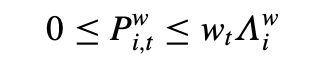

## Wind curtailment in per unit

In [86]:
model.pwc = Var(model.bus, model.t, bounds=lambda m, bus, t:(0, Wcap_max(m, bus, t)))

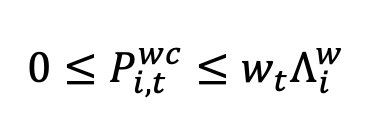

## SOC limits in per unit

In [87]:
def SOC_Bound(model, bus, t):    
    return (0.2*SOCMax[bus] / Sbase,  1*SOCMax[bus] / Sbase)

In [88]:
model.SOC = Var(model.bus, model.t, bounds= lambda m, b,t : SOC_Bound(m,b,t))

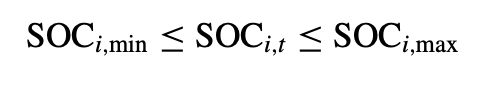

#### assumption for SOC

In [89]:
for bus in model.bus:
    model.SOC[bus, 't24'].fix(SOC0[bus])

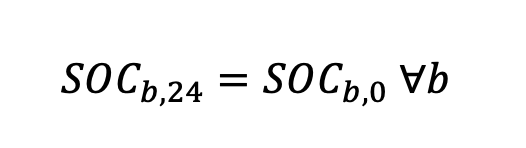

## Charge and discharge of storage , in per unit

In [90]:
model.Pc = Var(model.bus, model.t, bounds=lambda m, bus, t:(0, 0.2*SOCMax[bus] / Sbase))

In [91]:
model.Pd = Var(model.bus, model.t, bounds=lambda m, bus, t:(0, 0.2*SOCMax[bus] / Sbase))

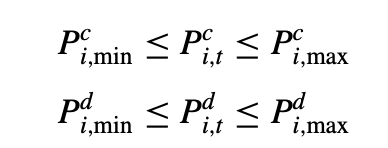

## Constraints

##### limit on output of power stations

In [92]:
#model.Pg = Var(model.Gen, model.t)

In [93]:
# pg_lb ={}
# pg_ub = {}

# for i in model.Gen: 
#     for k in model.t: 
#         pg_lb[i,k]= Pmin(model, i, k)
#         pg_ub[i,k]= Pmax(model, i, k)

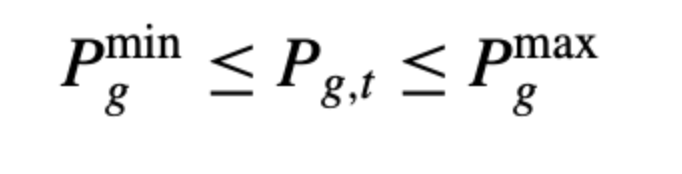

In [94]:
# def pg_LB_Bound(model, Gen, t):
#     return model.Pg[Gen, t] >= pg_lb[Gen,t]

In [95]:
# model.PG_LB_BOUND = Constraint(model.Gen, model.t, rule=pg_LB_Bound)

In [96]:
# def pg_UB_Bound(model, Gen, t):
#     return model.Pg[Gen, t] <= pg_ub[Gen,t]

In [97]:
# model.PG_UB_BOUND = Constraint(model.Gen, model.t, rule=pg_UB_Bound)

#### soc

In [98]:
def constESS_rule(model, bus, t):
    if SOCMax[bus] > 0:
        if t == 't1':  # First time period
            return model.SOC[bus, t] == SOC0[bus]+ model.Pc[bus,t]*eta_c-model.Pd[bus, t] / eta_d
        else:
            return model.SOC[bus,t]==model.SOC[bus,t_hours[t_hours.index(t)-1]] + model.Pc[bus,t]*eta_c-model.Pd[bus, t] / eta_d
    else:
        return Constraint.Skip

In [99]:
if storage_pos ==1:
    model.constESS = Constraint(model.bus, model.t, rule=constESS_rule)
else:
    pass

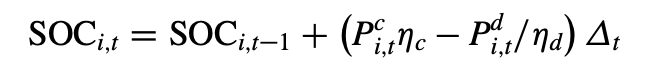

#### ramp up

In [100]:
def const4_rule(model, gen, t):
    if t == 't24':
        return Constraint.Skip    
    return model.Pg[gen, t_hours[t_hours.index(t) + 1]] - model.Pg[gen, t] <= GD[gen,'RU'] / Sbase

In [101]:
model.const4 = Constraint(model.Gen, model.t, rule=const4_rule)

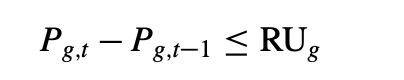

In [102]:
def const5_rule(model, gen, t):
    if t == 't1':
        return Constraint.Skip
    return model.Pg[gen, t_hours[t_hours.index(t) - 1]] - model.Pg[gen, t] <= GD[gen,'RD'] / Sbase

In [103]:
model.const5 = Constraint(model.Gen, model.t, rule=const5_rule)

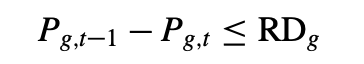

In [104]:
def const6_rule(model, bus, t):
    if Wcap_data[bus] > 0:
        return model.pwc[bus, t] == WD[t]['w'] * Wcap_data[bus] / Sbase - model.Pw[bus, t]
    else:
        return Constraint.Skip

In [105]:
model.const6 = Constraint(model.bus, model.t, rule=const6_rule)

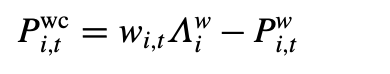

In [106]:
def const1_rule(model, bus, node, t):
    if (bus, node) in branch:        #(bus, node) in conex:# and 
        return model.Pij[bus, node, t] == branch[bus, node]['bij'] * (model.delta[bus, t] - model.delta[node, t])        
    else:
        return Constraint.Skip

In [107]:
model.const1 = Constraint(model.bus, model.node, model.t, rule=const1_rule)

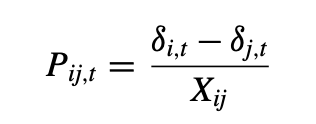

## Load shedding (curtailed load)

In [108]:
def BusData_max(model, bus, t):
    return WD[t]['d']* BusData[bus]['pd'] / Sbase

In [109]:
model.lsh = Var(model.bus, model.t, bounds=lambda m, bus, t: (0, BusData_max(m, bus, t)))

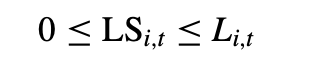

In [110]:
BusData

{1: {'pd': 108},
 2: {'pd': 97},
 3: {'pd': 180},
 4: {'pd': 74},
 5: {'pd': 71},
 6: {'pd': 136},
 7: {'pd': 125},
 8: {'pd': 171},
 9: {'pd': 175},
 10: {'pd': 195},
 11: {'pd': 0},
 12: {'pd': 0},
 13: {'pd': 265},
 14: {'pd': 194},
 15: {'pd': 317},
 16: {'pd': 100},
 17: {'pd': 0},
 18: {'pd': 333},
 19: {'pd': 181},
 20: {'pd': 128},
 21: {'pd': 0},
 22: {'pd': 0},
 23: {'pd': 0},
 24: {'pd': 0}}

In [111]:
for i in model.bus:
    for k in model.t:
        print(WD[k]['d']* BusData[i]['pd'] / Sbase)
        print(BusData_max(model, i, k))
        print()

0.739272242331873
0.739272242331873

0.6956525052390928
0.6956525052390928

0.6621146885120975
0.6621146885120975

0.6477119451324065
0.6477119451324065

0.6359839969518003
0.6359839969518003

0.6458601638407321
0.6458601638407321

0.6458601638407321
0.6458601638407321

0.7038826443132022
0.7038826443132022

0.7625223852162317
0.7625223852162317

0.8499676128786436
0.8499676128786436

0.9061383120594404
0.9061383120594404

0.9209525623928363
0.9209525623928363

0.9402933892169938
0.9402933892169938

0.9009944751381218
0.9009944751381218

0.8818594017908177
0.8818594017908177

0.8849457039436085
0.8849457039436085

0.9439969518003427
0.9439969518003427

1.08
1.08

1.0623052009906646
1.0623052009906646

1.0112783387311866
1.0112783387311866

0.9586054486568872
0.9586054486568872

0.8740407696704139
0.8740407696704139

0.8055248618784527
0.8055248618784527

0.7921508858830256
0.7921508858830256

0.6639759954277008
0.6639759954277008

0.6247990093351111
0.6247990093351111

0.59467708134882

## power balance

In [112]:
def const2_rule(model, bus, t):
    item_base = sum(model.Pg[gen, t] for gen in model.Gen if GB[bus, gen] == 1) - WD[t]['d']*BusData[bus]['pd']/Sbase
    
    if BusData[bus]['pd'] > 0:
        item_base += model.lsh[bus, t]    #load shedding
        
    if Wcap_data[bus] > 0:
        item_base += model.Pw[bus, t]     #output from wind unit
        
    if SOCMax[bus] > 0 and storage_pos == 1 :
        item_base += model.Pd[bus, t] - model.Pc[bus, t]   #storage discharge - charge
    
  
    item_base += sum(model.Pij[bus, node, t] for node in model.node if (node,bus) in branch)
                             
    return item_base == 0

In [113]:
model.const2 = Constraint(model.bus, model.t, rule= lambda m,b,t: const2_rule(m,b,t) )

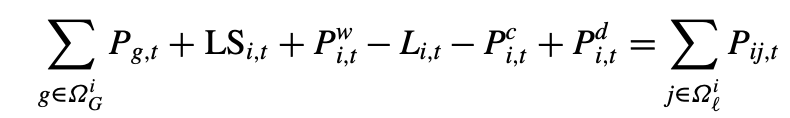

## Objective function

In [114]:
def const3_rule(model): 
    item1 = sum(model.Pg[gen, t] * GD[gen,'b'] * Sbase for t in model.t for gen in model.Gen) 
    item2 = sum(VOLL*model.lsh[bus,t]*Sbase for t in model.t for bus in model.bus )  
    item3 = sum(VOLW*model.pwc[bus,t]*Sbase for t in model.t for bus in model.bus) 
    return item1 + item2 + item3

In [115]:
model.obj = Objective(expr=const3_rule, sense=minimize)

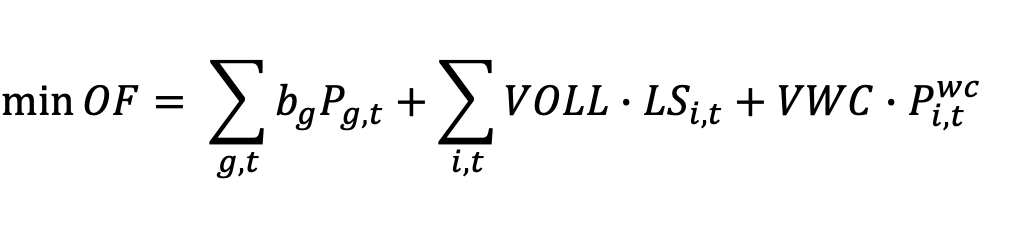

## Solve

In [116]:
solver = SolverFactory('gurobi')

In [117]:
results = solver.solve(model)

In [118]:
results

{'Problem': [{'Name': 'x18145', 'Lower bound': 432857.2192957688, 'Upper bound': 432857.2192957688, 'Number of objectives': 1, 'Number of constraints': 2833, 'Number of variables': 3697, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 3697, 'Number of nonzeros': 8401, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.03125190734863281', 'Error rc': 0, 'Time': 0.31247401237487793}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [119]:
results['Problem'][0]['Number of objectives']  

1

In [120]:
results['Problem'][0]['Lower bound']  

432857.2192957688

In [121]:
results['Problem'][0]['Upper bound']  

432857.2192957688

In [122]:
results['Problem'][0]['Number of constraints']  

2833

In [123]:
results['Solver'][0]['Message']

'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'

In [124]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 432857.2192957686


In [125]:
model.display()

Model multi-period ESS integrated DC-OPF

  Variables:
    delta : Size=576, Index=delta_index
        Key         : Lower               : Value                 : Upper              : Fixed : Stale : Domain
          (1, 't1') : -1.5707963267948966 :   0.20313269231599262 : 1.5707963267948966 : False : False :  Reals
         (1, 't10') : -1.5707963267948966 :   0.22845172085971988 : 1.5707963267948966 : False : False :  Reals
         (1, 't11') : -1.5707963267948966 :    0.2623244388726116 : 1.5707963267948966 : False : False :  Reals
         (1, 't12') : -1.5707963267948966 :   0.27160747207563496 : 1.5707963267948966 : False : False :  Reals
         (1, 't13') : -1.5707963267948966 :     0.267817882371971 : 1.5707963267948966 : False : False :  Reals
         (1, 't14') : -1.5707963267948966 :    0.2560552741682911 : 1.5707963267948966 : False : False :  Reals
         (1, 't15') : -1.5707963267948966 :    0.2543237131428868 : 1.5707963267948966 : False : False :  Reals
         

        Key             : Lower : Value                  : Upper : Fixed : Stale : Domain
           (1, 1, 't1') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't10') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't11') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't12') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't13') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't14') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't15') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't16') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't17') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (1, 1, 't18') :   0.0 :                   None :   0.0 : False :  True :  Reals
          

          (1, 5, 't11') : -1.75 :    0.12875155994812282 :  1.75 : False : False :  Reals
          (1, 5, 't12') : -1.75 :     0.1343768571862487 :  1.75 : False : False :  Reals
          (1, 5, 't13') : -1.75 :    0.13064544489949403 :  1.75 : False : False :  Reals
          (1, 5, 't14') : -1.75 :     0.1425554461487164 :  1.75 : False : False :  Reals
          (1, 5, 't15') : -1.75 :    0.15404612549973384 :  1.75 : False : False :  Reals
          (1, 5, 't16') : -1.75 :    0.13146758942359682 :  1.75 : False : False :  Reals
          (1, 5, 't17') : -1.75 :    0.06843707667029686 :  1.75 : False : False :  Reals
          (1, 5, 't18') : -1.75 :   0.027153343008643915 :  1.75 : False : False :  Reals
          (1, 5, 't19') : -1.75 :   -0.05580050824479699 :  1.75 : False : False :  Reals
           (1, 5, 't2') : -1.75 :   0.017061477068377684 :  1.75 : False : False :  Reals
          (1, 5, 't20') : -1.75 :   -0.07460486999386484 :  1.75 : False : False :  Reals
          

         (3, 12, 't23') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (3, 12, 't24') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't3') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't4') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't5') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't6') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't7') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't8') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 12, 't9') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (3, 13, 't1') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (3, 13, 't10') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (

         (6, 10, 't10') : -1.75 :      1.033539820349708 :  1.75 : False : False :  Reals
         (6, 10, 't11') : -1.75 :     1.1759208545226016 :  1.75 : False : False :  Reals
         (6, 10, 't12') : -1.75 :     1.1975482842251362 :  1.75 : False : False :  Reals
         (6, 10, 't13') : -1.75 :     1.2157789287623135 :  1.75 : False : False :  Reals
         (6, 10, 't14') : -1.75 :     1.1783906711567744 :  1.75 : False : False :  Reals
         (6, 10, 't15') : -1.75 :     1.1623342806803691 :  1.75 : False : False :  Reals
         (6, 10, 't16') : -1.75 :      1.146187593822816 :  1.75 : False : False :  Reals
         (6, 10, 't17') : -1.75 :     1.1734029860859039 :  1.75 : False : False :  Reals
         (6, 10, 't18') : -1.75 :     1.3082277125520845 :  1.75 : False : False :  Reals
         (6, 10, 't19') : -1.75 :      1.228722155302937 :  1.75 : False : False :  Reals
          (6, 10, 't2') : -1.75 :     0.8485142664310761 :  1.75 : False : False :  Reals
         (

         (9, 21, 't10') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't11') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't12') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't13') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't14') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't15') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't16') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't17') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't18') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (9, 21, 't19') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (9, 21, 't2') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (

         (12, 16, 't6') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (12, 16, 't7') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (12, 16, 't8') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (12, 16, 't9') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (12, 17, 't1') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (12, 17, 't10') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (12, 17, 't11') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (12, 17, 't12') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (12, 17, 't13') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (12, 17, 't14') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (12, 17, 't15') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (1

        (15, 16, 't14') :  -5.0 :    -0.8093506551199994 :   5.0 : False : False :  Reals
        (15, 16, 't15') :  -5.0 :   -0.42301087521105174 :   5.0 : False : False :  Reals
        (15, 16, 't16') :  -5.0 :   -0.13795621667561164 :   5.0 : False : False :  Reals
        (15, 16, 't17') :  -5.0 :    -0.5938358723562516 :   5.0 : False : False :  Reals
        (15, 16, 't18') :  -5.0 :    -0.5319690711933251 :   5.0 : False : False :  Reals
        (15, 16, 't19') :  -5.0 :    -0.5347435647114853 :   5.0 : False : False :  Reals
         (15, 16, 't2') :  -5.0 :     -1.407549428817907 :   5.0 : False : False :  Reals
        (15, 16, 't20') :  -5.0 :    -0.8059655575833311 :   5.0 : False : False :  Reals
        (15, 16, 't21') :  -5.0 :    -0.8648530870977016 :   5.0 : False : False :  Reals
        (15, 16, 't22') :  -5.0 :    -0.7226361660304068 :   5.0 : False : False :  Reals
        (15, 16, 't23') :  -5.0 :   -0.48380169512914684 :   5.0 : False : False :  Reals
        (1

        (18, 15, 't12') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't13') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't14') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't15') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't16') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't17') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't18') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't19') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (18, 15, 't2') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't20') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (18, 15, 't21') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (1

         (21, 24, 't9') :   0.0 :                   None :   0.0 : False :  True :  Reals
          (22, 1, 't1') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't10') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't11') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't12') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't13') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't14') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't15') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't16') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't17') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (22, 1, 't18') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (

         (24, 23, 't4') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (24, 23, 't5') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (24, 23, 't6') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (24, 23, 't7') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (24, 23, 't8') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (24, 23, 't9') :   0.0 :                   None :   0.0 : False :  True :  Reals
         (24, 24, 't1') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (24, 24, 't10') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (24, 24, 't11') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (24, 24, 't12') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (24, 24, 't13') :   0.0 :                   None :   0.0 : False :  True :  Reals
        (2

        (19, 't21') :   0.4 :  None :   2.0 : False :  True :  Reals
        (19, 't22') :   0.4 :  None :   2.0 : False :  True :  Reals
        (19, 't23') :   0.4 :  None :   2.0 : False :  True :  Reals
        (19, 't24') :   0.4 :   0.4 :   2.0 :  True :  True :  Reals
         (19, 't3') :   0.4 :  None :   2.0 : False :  True :  Reals
         (19, 't4') :   0.4 :  None :   2.0 : False :  True :  Reals
         (19, 't5') :   0.4 :  None :   2.0 : False :  True :  Reals
         (19, 't6') :   0.4 :  None :   2.0 : False :  True :  Reals
         (19, 't7') :   0.4 :  None :   2.0 : False :  True :  Reals
         (19, 't8') :   0.4 :  None :   2.0 : False :  True :  Reals
         (19, 't9') :   0.4 :  None :   2.0 : False :  True :  Reals
         (20, 't1') :   0.0 :  None :   0.0 : False :  True :  Reals
        (20, 't10') :   0.0 :  None :   0.0 : False :  True :  Reals
        (20, 't11') :   0.0 :  None :   0.0 : False :  True :  Reals
        (20, 't12') :   0.0 :  Non

        (14, 't15') :     0 :   0.0 :  1.5840807772909133 : False : False :  Reals
        (14, 't16') :     0 :   0.0 :  1.5896246904172227 : False : False :  Reals
        (14, 't17') :     0 :   0.0 :   1.695698228233949 : False : False :  Reals
        (14, 't18') :     0 :   0.0 :                1.94 : False : False :  Reals
        (14, 't19') :     0 :   0.0 :  1.9082148980758233 : False : False :  Reals
         (14, 't2') :     0 :   0.0 :  1.2495980186702222 : False : False :  Reals
        (14, 't20') :     0 :   0.0 :  1.8165555343875015 : False : False :  Reals
        (14, 't21') :     0 :   0.0 :  1.7219394170318159 : False : False :  Reals
        (14, 't22') :     0 :   0.0 :  1.5700361973709287 : False : False :  Reals
        (14, 't23') :     0 :   0.0 :  1.4469613259668503 : False : False :  Reals
        (14, 't24') :     0 :   0.0 :  1.4229377024195091 : False : False :  Reals
         (14, 't3') :     0 :   0.0 :   1.189354162697657 : False : False :  Reals
    

          (5, 't5') :   0.0 :   5.551115123125783e-17 :   0.0
          (5, 't6') :   0.0 :  -2.220446049250313e-16 :   0.0
          (5, 't7') :   0.0 :   2.220446049250313e-16 :   0.0
          (5, 't8') :   0.0 :                     0.0 :   0.0
          (5, 't9') :   0.0 :   2.220446049250313e-16 :   0.0
          (6, 't1') :   0.0 :   2.220446049250313e-16 :   0.0
         (6, 't10') :   0.0 :                     0.0 :   0.0
         (6, 't11') :   0.0 :   2.220446049250313e-16 :   0.0
         (6, 't12') :   0.0 :   2.220446049250313e-16 :   0.0
         (6, 't13') :   0.0 :   2.220446049250313e-16 :   0.0
         (6, 't14') :   0.0 :                     0.0 :   0.0
         (6, 't15') :   0.0 :  -2.220446049250313e-16 :   0.0
         (6, 't16') :   0.0 :  -2.220446049250313e-16 :   0.0
         (6, 't17') :   0.0 :   2.220446049250313e-16 :   0.0
         (6, 't18') :   0.0 :   2.220446049250313e-16 :   0.0
         (6, 't19') :   0.0 :  -2.220446049250313e-16 :   0.0
        

In [126]:
model.SOC.display()

SOC : Size=576, Index=SOC_index
    Key         : Lower : Value : Upper : Fixed : Stale : Domain
      (1, 't1') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't10') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't11') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't12') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't13') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't14') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't15') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't16') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't17') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't18') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't19') :   0.0 :  None :   0.0 : False :  True :  Reals
      (1, 't2') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't20') :   0.0 :  None :   0.0 : False :  True :  Reals
     (1, 't21') :   0.0 :  None :   0.0 : False :  True : 

In [127]:
model.const1.display()

const1 : Size=1632
    Key             : Lower : Body                    : Upper
       (1, 2, 't1') :   0.0 :  4.6351811278100286e-15 :   0.0
      (1, 2, 't10') :   0.0 :  -2.914335439641036e-15 :   0.0
      (1, 2, 't11') :   0.0 :  -8.215650382226158e-15 :   0.0
      (1, 2, 't12') :   0.0 : -2.3869795029440866e-15 :   0.0
      (1, 2, 't13') :   0.0 :    9.71445146547012e-15 :   0.0
      (1, 2, 't14') :   0.0 :  -1.970645868709653e-15 :   0.0
      (1, 2, 't15') :   0.0 : -1.6653345369377348e-16 :   0.0
      (1, 2, 't16') :   0.0 :    9.46465128492946e-15 :   0.0
      (1, 2, 't17') :   0.0 :   9.645062526431047e-15 :   0.0
      (1, 2, 't18') :   0.0 : -1.3600232051658168e-15 :   0.0
      (1, 2, 't19') :   0.0 : -2.7478019859472624e-15 :   0.0
       (1, 2, 't2') :   0.0 :  -3.635980405647388e-15 :   0.0
      (1, 2, 't20') :   0.0 :  5.9674487573602164e-15 :   0.0
      (1, 2, 't21') :   0.0 : -5.6066262743570405e-15 :   0.0
      (1, 2, 't22') :   0.0 :   8.520961713998076e-

     (22, 21, 't6') :   0.0 : -2.4424906541753444e-15 :   0.0
     (22, 21, 't7') :   0.0 :   8.881784197001252e-16 :   0.0
     (22, 21, 't8') :   0.0 :   2.220446049250313e-16 :   0.0
     (22, 21, 't9') :   0.0 :   2.220446049250313e-15 :   0.0
     (23, 12, 't1') :   0.0 :   2.220446049250313e-16 :   0.0
    (23, 12, 't10') :   0.0 :   2.220446049250313e-16 :   0.0
    (23, 12, 't11') :   0.0 :  1.3322676295501878e-15 :   0.0
    (23, 12, 't12') :   0.0 : -1.3322676295501878e-15 :   0.0
    (23, 12, 't13') :   0.0 :  -8.881784197001252e-16 :   0.0
    (23, 12, 't14') :   0.0 :  -4.440892098500626e-16 :   0.0
    (23, 12, 't15') :   0.0 :                     0.0 :   0.0
    (23, 12, 't16') :   0.0 :                     0.0 :   0.0
    (23, 12, 't17') :   0.0 :                     0.0 :   0.0
    (23, 12, 't18') :   0.0 :   4.440892098500626e-16 :   0.0
    (23, 12, 't19') :   0.0 :                     0.0 :   0.0
     (23, 12, 't2') :   0.0 :  1.5543122344752192e-15 :   0.0
    (23,

In [128]:
model.pwc.display()

pwc : Size=576, Index=pwc_index
    Key         : Lower : Value              : Upper               : Fixed : Stale : Domain
      (1, 't1') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't10') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't11') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't12') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't13') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't14') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't15') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't16') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't17') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (1, 't18') :     0 :                0.0 :  

      (5, 't5') :     0 :                0.0 :                 0.0 : False : False :  Reals
      (5, 't6') :     0 :                0.0 :                 0.0 : False : False :  Reals
      (5, 't7') :     0 :                0.0 :                 0.0 : False : False :  Reals
      (5, 't8') :     0 :                0.0 :                 0.0 : False : False :  Reals
      (5, 't9') :     0 :                0.0 :                 0.0 : False : False :  Reals
      (6, 't1') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (6, 't10') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (6, 't11') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (6, 't12') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (6, 't13') :     0 :                0.0 :                 0.0 : False : False :  Reals
     (6, 't14') :     0 :                0.0 :                 0.0 : False : Fal

#### delta

In [129]:
pd.set_option('display.max_columns', None)

In [130]:
delta_dic = {}

In [131]:
for bus in model.bus:
    delta_lst = []
    for t in model.t:
        delta_lst.append(model.delta[bus, t].value)
    delta_dic[bus] = delta_lst

In [132]:
delta_dic

{1: [0.20313269231599262,
  0.20446929307532247,
  0.19398526310184172,
  0.18696315239239691,
  0.18154697237915474,
  0.17961136857634563,
  0.17783369278016492,
  0.19917080764016615,
  0.22131412721915455,
  0.22845172085971988,
  0.2623244388726116,
  0.27160747207563496,
  0.267817882371971,
  0.2560552741682911,
  0.2543237131428868,
  0.2493588808441376,
  0.24614290989526655,
  0.2756454062979594,
  0.2596160150071489,
  0.24420196437448083,
  0.24820119108858152,
  0.2415855000830367,
  0.23575476553002273,
  0.2253219371290327],
 2: [0.20568836901199972,
  0.20719562148306236,
  0.19644741885546213,
  0.18914335416306716,
  0.18351179594969258,
  0.18139641120587968,
  0.1795105328490063,
  0.20126830900414405,
  0.22381681329704817,
  0.23115858435663905,
  0.2653115876334,
  0.2746417854335579,
  0.27030132229978343,
  0.25882300052430374,
  0.25678882031342787,
  0.2507231643587682,
  0.24756560281728857,
  0.27746780604546695,
  0.26100306292696174,
  0.24696651652814827

In [133]:
df_delta = pd.DataFrame(delta_dic) 

In [134]:
df_delta # row is time and column is buses. This is also true for all other dataframes below

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.203133,0.205688,0.087880,0.192059,0.206649,0.219409,0.246738,0.240251,0.128375,0.167410,0.034468,0.041953,0,-0.048284,-0.199762,-0.176951,-0.276801,-0.311727,-0.132275,-0.116175,-0.320891,-0.427354,-0.116857,-0.089831
1,0.204469,0.207196,0.083931,0.187918,0.203028,0.212474,0.226480,0.223094,0.122711,0.161139,0.032627,0.041794,0,-0.047630,-0.195278,-0.170927,-0.271076,-0.306272,-0.124656,-0.105505,-0.313930,-0.420877,-0.103963,-0.088570
2,0.193985,0.196447,0.084434,0.178706,0.192588,0.201533,0.204436,0.203433,0.117139,0.152692,0.033296,0.040362,0,-0.038722,-0.173186,-0.152010,-0.242704,-0.273019,-0.111748,-0.095724,-0.281037,-0.389755,-0.095458,-0.074729
3,0.186963,0.189143,0.087453,0.171575,0.184479,0.192556,0.169634,0.169654,0.111173,0.144285,0.034174,0.038252,0,-0.029037,-0.150199,-0.133122,-0.213351,-0.238616,-0.101894,-0.088938,-0.247607,-0.354784,-0.090162,-0.059374
4,0.181547,0.183512,0.089764,0.166125,0.178272,0.185696,0.143786,0.144640,0.106705,0.137931,0.034859,0.036683,0,-0.021676,-0.132531,-0.118729,-0.191298,-0.212197,-0.094282,-0.083699,-0.221684,-0.333514,-0.086068,-0.047574
5,0.179611,0.181396,0.092728,0.162813,0.174634,0.181207,0.107331,0.107483,0.101713,0.131942,0.035007,0.034584,0,-0.015781,-0.119571,-0.108175,-0.172847,-0.190848,-0.091425,-0.081671,-0.204226,-0.304142,-0.084617,-0.038435
6,0.177834,0.179511,0.094367,0.160615,0.172147,0.178300,0.090621,0.090773,0.099259,0.128713,0.035218,0.033615,0,-0.012341,-0.111062,-0.101730,-0.163189,-0.181629,-0.088820,-0.079861,-0.191554,-0.278215,-0.083241,-0.032551
7,0.199171,0.201268,0.097845,0.179610,0.193170,0.200049,0.136709,0.132738,0.111870,0.146039,0.036016,0.036511,0,-0.024962,-0.142625,-0.130894,-0.204269,-0.226996,-0.110365,-0.099297,-0.237008,-0.336391,-0.102269,-0.050722
8,0.221314,0.223817,0.102569,0.199309,0.214864,0.222400,0.183303,0.175164,0.125071,0.163861,0.037411,0.039411,0,-0.036409,-0.172047,-0.158389,-0.242670,-0.269542,-0.131496,-0.119372,-0.279535,-0.388828,-0.122520,-0.067094
9,0.228452,0.231159,0.105761,0.210703,0.226780,0.238222,0.208899,0.194547,0.133568,0.175693,0.037802,0.039990,0,-0.045413,-0.197236,-0.182247,-0.274073,-0.304753,-0.152685,-0.139276,-0.315579,-0.423054,-0.142842,-0.081437


#### pc

In [135]:
pc_dic = {}

In [136]:
for bus in model.bus:
    pc_lst = []
    for t in model.t:
        pc_lst.append(model.Pc[bus, t].value)
    pc_dic[bus] = pc_lst


In [137]:
df_pc = pd.DataFrame(pc_dic) #.fillna(0) 

In [138]:
df_pc

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


#### pwc

In [139]:
pwc_dic = {}

In [140]:
for bus in model.bus:
    pwc_lst = []
    for t in model.t:
        pwc_lst.append(model.pwc[bus, t].value)
    pwc_dic[bus] = pwc_lst



In [141]:
df_pwc = pd.DataFrame(pwc_dic)#.fillna(0) 

In [142]:
df_pwc

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [143]:
df_pwc.sum().sum() 

1.410235473423187

#### pd

In [144]:
pd_dic = {}

In [145]:
for bus in model.bus:
    pd_lst = []
    for t in model.t:
        pd_lst.append(model.Pd[bus, t].value)
    pd_dic[bus] = pd_lst

df_pd = pd.DataFrame(pd_dic).fillna(0) 

In [146]:
df_pd

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### soc

In [147]:
soc_dic = {}

In [148]:
for bus in model.bus:
    soc_lst = []
    for t in model.t:
        soc_lst.append(model.SOC[bus, t].value)
    soc_dic[bus] = soc_lst

In [149]:
df_soc = pd.DataFrame(soc_dic).fillna(0) 

In [150]:
df_soc

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### lsh

In [151]:
lsh_dic = {}

In [152]:
for bus in model.bus:
    lsh_lst = []
    for t in model.t:
        lsh_lst.append(model.lsh[bus, t].value)
    lsh_dic[bus] = lsh_lst

In [153]:
df_lsh = pd.DataFrame(lsh_dic).fillna(0) 

In [154]:
df_lsh

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
df_lsh.sum().sum()

0.0

#### pg

In [156]:
pg_dic = {}

In [157]:
for gen in model.Gen:
    pg_lst = []
    
    for t in model.t:
        pg_lst.append(model.Pg[gen, t].value)
      
    pg_dic[gen] = pg_lst


In [158]:
pg_dic

{'g1': [4.0,
  4.0,
  3.5300000000000002,
  3.0600000000000005,
  2.6824400838254645,
  2.2124400838254648,
  2.5084697085158973,
  2.978469708515897,
  3.448469708515897,
  3.9184697085158966,
  4.0,
  4.0,
  4.0,
  3.5300000000000002,
  3.0600000000000005,
  3.0600000000000005,
  3.5300000000000002,
  4.0,
  4.0,
  4.0,
  4.0,
  3.5300000000000002,
  3.0600000000000005,
  3.005075633453999],
 'g2': [4.0,
  3.767970946847022,
  3.2979709468470224,
  2.8279709468470227,
  2.357970946847023,
  2.44402962469,
  2.120000000000001,
  2.5900000000000007,
  3.0600000000000005,
  3.5300000000000002,
  4.0,
  4.0,
  4.0,
  3.927328253000593,
  3.4573282530005933,
  3.0600000000000005,
  3.5300000000000002,
  4.0,
  4.0,
  4.0,
  4.0,
  3.5300000000000002,
  3.0600000000000005,
  2.5900000000000007],
 'g3': [0.41904734235140084,
  0.304,
  0.304,
  0.304,
  0.304,
  0.304,
  0.304,
  0.304,
  0.304,
  0.444,
  0.304,
  0.304,
  0.304,
  0.304,
  0.304,
  0.304,
  0.444,
  0.5840000000000001,
  

In [159]:

df_pg = pd.DataFrame(pg_dic).fillna(0) 

In [160]:
df_pg

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12
0,4.000000,4.000000,0.419047,0.444000,0.542500,0.752500,1.378026,1.680000,0.750000,2.0685,0.12,3.000000
1,4.000000,3.767971,0.304000,0.304000,0.542500,0.542500,1.168026,1.400000,0.750000,2.0685,0.12,3.000000
2,3.530000,3.297971,0.304000,0.304000,0.542500,0.542500,1.085000,1.400000,0.750000,2.0685,0.12,3.000000
3,3.060000,2.827971,0.304000,0.304000,0.542500,0.542500,1.085000,1.400000,0.750000,2.0685,0.12,2.923928
4,2.682440,2.357971,0.304000,0.304000,0.542500,0.542500,1.085000,1.400000,0.750000,2.0685,0.12,3.000000
5,2.212440,2.444030,0.304000,0.304000,0.542500,0.542500,1.085000,1.400000,0.750000,2.0685,0.12,2.720562
6,2.508470,2.120000,0.304000,0.304000,0.542500,0.542500,1.085000,1.400000,0.750000,2.0685,0.12,2.370562
7,2.978470,2.590000,0.304000,0.304000,0.542500,0.752500,1.295000,1.599149,0.750000,2.0685,0.12,2.720562
8,3.448470,3.060000,0.304000,0.304000,0.542500,0.962500,1.505000,1.879149,0.750000,2.0685,0.12,3.000000
9,3.918470,3.530000,0.444000,0.444000,0.642082,1.172500,1.715000,2.159149,0.750000,2.0685,0.12,3.000000


#### pij

In [161]:
p_columns = ['bus', 'node']

In [162]:
p_columns += [*range(1, 25)]
p_columns

['bus',
 'node',
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [163]:
df_pij = pd.DataFrame(columns=p_columns)

In [164]:
df_pij

,bus,node,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24


In [165]:
pd.set_option('display.max_rows', None)

In [166]:
for bus in model.bus:
    for node in model.node:
        pij_lst = [bus, node]
        for t in model.t:
            pij_lst.append(model.Pij[bus,node, t].value)
        df_pij.loc[len(df_pij)] = pij_lst

In [167]:

df_pij = df_pij#.fillna(0)
print("\nPij value table(column: time)\n")  
df_pij


Pij value table(column: time)



,bus,node,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,-0.183862,-0.196139,-0.177134,-0.156849,-0.141354,-0.128420,-0.120636,-0.150899,-0.180049,-0.194738,-0.214903,-0.218296,-0.178665,-0.199117,-0.177346,-0.098150,-0.102352,-0.131108,-0.099788,-0.198889,-0.204347,-0.188201,-0.165552,-0.156735
2,1.0,3.0,0.545705,0.570730,0.518707,0.471167,0.434581,0.411381,0.395200,0.479763,0.562241,0.580921,0.688290,0.700872,0.684313,0.653556,0.601159,0.547628,0.533912,0.599955,0.561284,0.560772,0.596950,0.576317,0.548155,0.524835
3,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,5.0,-0.041619,0.017061,0.016541,0.029394,0.038757,0.058899,0.067296,0.071019,0.076330,0.019785,0.128752,0.134377,0.130645,0.142555,0.154046,0.131468,0.068437,0.027153,-0.055801,-0.074605,-0.017997,0.041925,0.118922,0.120051
5,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


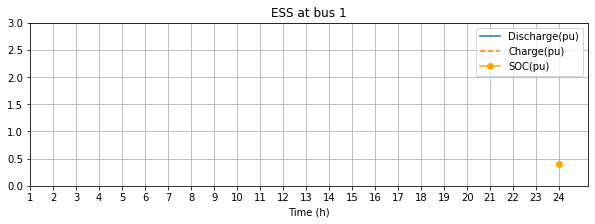

In [168]:
plt.figure(figsize=(10, 3))
plt.plot(t_hours, pd_dic[19], '-', label='Discharge(pu)')
plt.plot(t_hours, pc_dic[19], '-', label='Charge(pu)', linestyle='dashed')
plt.plot(t_hours, soc_dic[19], 'o-', color='orange', label='SOC(pu)')

plt.ylim([0,3])
plt.xlabel('Time (h)')
plt.title('ESS at bus 1')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.legend()
plt.grid()
plt.show()

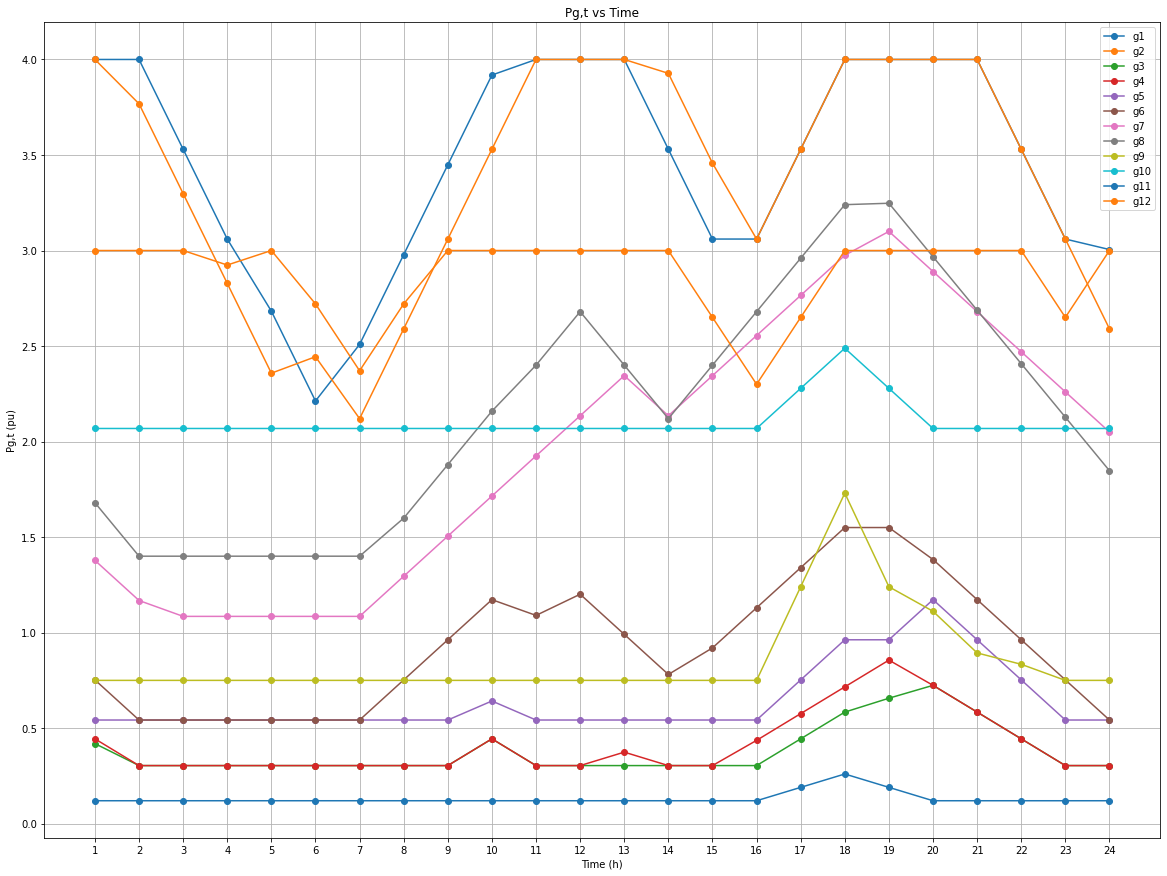

In [169]:
plt.figure(figsize=(20, 15))
for gen in model.Gen:
    plt.plot(t_hours, df_pg[gen], 'o-', label=gen)
plt.xlabel('Time (h)')
plt.ylabel('Pg,t (pu)')
plt.title('Pg,t vs Time')
plt.xticks(t_hours, xticks)
plt.legend()
plt.grid()
plt.show()